##  Analysis of a claim
To Check on Checkability, the first workflow of the EUFactcheck programme will be followed (https://eufactcheck.eu/about-us/eufactcheck-flowchart/). The student will also be involved to provide more information and to check the output.

In [1]:
import getpass
import os
from dotenv import load_dotenv
from langchain_groq import ChatGroq
#from langchain_ollama import ChatOllama
import tqdm as notebook_tqdm
from tavily import TavilyClient
import sys
import os

# Load alle the API keys
load_dotenv(dotenv_path=".env", override=True)

# Initialize Tavily client 
tavily_client = TavilyClient(api_key=os.getenv("TAVILY_API_KEY", ""))

#os.environ["LANGSMITH_TRACING"] = "true"
#os.environ["LANGSMITH_ENDPOINT"]="https://api.smith.langchain.com"
#os.environ["LANGSMITH_PROJECT"]="pr-left-technician-100"

#low temperature for more factual answers,
#llm = ChatOllama(model="qwen3:4b", temperature=0.1, base_url="http://localhost:11434")
llm = ChatGroq(model_name="qwen/qwen3-32b", temperature=0.1)

sys.path.append(os.path.abspath("./src"))

c:\temp\checkmate\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Functions of all the nodes in Claim analysis

These functions are all the nodes in the claim graph and also show the edges in case of conditional nodes

In [ ]:
""" All the nodes """

from prompts import (
    checkable_check_prompt,
    confirmation_checkable_prompt,
    get_information_prompt,
    confirmation_clarification_prompt,
    get_summary_prompt,
    confirmation_check_prompt,
    rag_queries_prompt,
    match_check_prompt,
    structure_claim_prompt,
    identify_source_prompt,
    source_location_prompt,
    source_queries_prompt,
    confirm_queries_prompt,
    select_primary_source_prompt,
    search_queries_prompt,
    iterate_search_prompt,
    get_socratic_question,
)
from state_scope import (
    AgentStateClaim, 
    SubjectResult, 
    MoreInfoResult, 
    SummaryResult, 
    ConfirmationResult,
    ConfirmationFinalResult,
    ConfirmationMatch,
    ClaimMatchingOutput,
    GetSource, 
    GetSourceLocation,
    GetSearchQueries,
    PrimarySourceSelection, 
)
from langgraph.types import Overwrite
from langchain_core.messages import BaseMessage,HumanMessage,AIMessage, ToolMessage, get_buffer_string
from typing import List, Dict, Any, Literal
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.types import Command, Send
from utils import get_new_user_reply,_domain
from tooling import llm, llm_tools, llm_tuned, tools_dict
import json


# Maximum number of messages to send to the prompt
MAX_HISTORY_MESSAGES = 6
# ───────────────────────────────────────────────────────────────────────
# ROUTER NODE
# ───────────────────────────────────────────────────────────────────────

# def router(state: AgentStateClaim) -> Command[
#     Literal[
#         "checkable_fact",
#         "checkable_confirmation",
#         "retrieve_information",
#         "clarify_information",
#         "produce_summary",
#         "critical_question",
#         "get_confirmation",
#         "get_rag_queries",
#         "confirm_rag_queries",
#         "rag_retrieve_worker",
#         "reduce_rag_results",
#         "structure_claim_matching",
#         "match_or_continue",
#         "get_source",
#         "get_location_source",
#         "get_source_queries",
#         "confirm_search_queries",
#         "select_primary_source",
#         "iterate_search",
#         ]
# ]:
#     """ Route to correct node, after user reply """

#     return Command(
#         goto=state.get("next_node") or "checkable_fact"
#         )

# # ───────────────────────────────────────────────────────────────────────
# # CRITICAL QUESTION NODE
# # ───────────────────────────────────────────────────────────────────────

def critical_question(state: AgentStateClaim) -> Command[Literal["checkable_confirmation","get_confirmation"]]:

    """ Ask a socratic question to make the user think about the consequences of a fact checking a claim """

    # retrieve alerts and format to string for the prompt
    alerts=state.get("alerts", [])
    alerts_str= "\n".join(f"- {a}" for a in alerts)

    # retrieve conversation history fact-check messages and critical messages
    conversation_history_critical = list(state.get("messages_critical", []))

    # Add the last messages into a string for the prompt
    messages_critical_str = get_buffer_string(conversation_history_critical[-MAX_HISTORY_MESSAGES:] )

    # Create a prompt
    prompt  =  get_socratic_question.format(
        alerts=alerts_str,
        claim=state.get("claim"),
        summary=state.get("summary"),
        messages_critical=messages_critical_str 
    )

    #invoke the LLM and store the output
    result = llm_tuned.invoke([HumanMessage(content=prompt)])

    ai_chat_msg = AIMessage(content=result.content)
  
    return Command(
        goto=state.get("next_node"),
            update={
                "critical_question": result.content,
                "messages_critical": [ai_chat_msg],
                "next_node": None
            }        
    )


# ───────────────────────────────────────────────────────────────────────
# CHECKABLE_FACT NODE
# ───────────────────────────────────────────────────────────────────────

def checkable_fact(state: AgentStateClaim) -> Command[Literal["checkable_confirmation"]]:

    """ Check if a claim is potentially checkable. """

    #Retrieve conversation history
    conversation_history = list(state.get("messages", []))

    # Add the last messages into a string for the prompt
    recent_messages = conversation_history[-MAX_HISTORY_MESSAGES:] 
    messages_str = get_buffer_string(recent_messages)

    # Use structured output
    structured_llm = llm.with_structured_output(SubjectResult, method="json_mode")

    # Create a prompt
    prompt = checkable_check_prompt.format(
        claim=state.get("claim", ""),
        additional_context=state.get("additional_context", ""),
        messages=messages_str,
    )

    #invoke the LLM and store the output
    result = structured_llm.invoke([HumanMessage(content=prompt)])

    # checkable is a boolean in State
    is_checkable = result.checkable == "POTENTIALLY CHECKABLE"

    # human-readable assistant message for the chat
    explanation_text = (
        f"**Checkability analysis**\n"
        f"- Checkable: `{result.checkable}`\n"
        f"- Reason: {result.explanation}\n"
    )

    ai_chat_msg = AIMessage(content=explanation_text)

    # Goto next node and update State
    return Command(
        goto="checkable_confirmation",
        update={
            "question": result.question,
            "checkable": is_checkable,
            "explanation": result.explanation,
            "messages": [ai_chat_msg],
            "awaiting_user": True,
            "next_node": "checkable_confirmation",
        }
    )

# ───────────────────────────────────────────────────────────────────────
# CHECKABLE_CONFIRMATION NODE
# ───────────────────────────────────────────────────────────────────────

def checkable_confirmation(state: AgentStateClaim) -> Command[Literal["retrieve_information","__end__","checkable_fact"]]:
    
    """ Get confirmation from user on the gathered information. """

    if state.get("awaiting_user"):

        ask_msg = AIMessage(content=state.get("question", ""))
        return Command(
            goto="__end__", 
            update={
                "messages": [ask_msg],
                "next_node": "checkable_confirmation",
                "awaiting_user": False,
            },
        )
    else:
        # Retrieve conversation history
        conversation_history = list(state.get("messages", []))

        # Get user reply, if the last message was a user message
        user_answer = get_new_user_reply(conversation_history)

        # Use structured output
        structured_llm = llm.with_structured_output(ConfirmationResult, method="json_mode")

        # Create a prompt
        prompt = confirmation_checkable_prompt.format(
            claim=state.get("claim", ""),
            checkable=state.get("checkable", ""),
            explanation=state.get("explanation", ""),
            user_answer=user_answer,
        )

        #invoke the LLM and store the output
        result = structured_llm.invoke([HumanMessage(content=prompt)])
        
        # human-readable assistant message for the chat
        if result.confirmed:
            confirm_text = "We'll continue with this claim."
        else:
            confirm_text = "Okay let's revise the claim or stop here."

        ai_chat_msg = AIMessage(content=confirm_text)

        # Goto next node and update State
        if result.confirmed:
            if state.get("checkable"):
                return Command(
                        goto="retrieve_information", 
                        update={
                            "confirmed": result.confirmed,
                            "messages": [ai_chat_msg],
                            "awaiting_user": False,
                            "additional_context": None,
                            "next_node": None
                        }
                )   
            else: 
                # user confirmed but claim is not checkable → end
                end_msg = AIMessage(content="This claim appears to be uncheckable, so we'll stop the process here.")
                return Command(
                        goto=END, 
                        update={
                            "confirmed": result.confirmed,
                            "messages": [ai_chat_msg] + [end_msg],
                            "awaiting_user": False,
                            "next_node": None
                        }
                )   
        else:
            return Command(
                    goto="checkable_fact", 
                    update={
                        "messages": [ai_chat_msg],
                        "awaiting_user": False,
                        "additional_context": user_answer,
                        "next_node": None
                    }
            )

# ───────────────────────────────────────────────────────────────────────
# RETRIEVE_INFORMATION NODE
# ───────────────────────────────────────────────────────────────────────

def retrieve_information(state: AgentStateClaim) -> Command[Literal["clarify_information"]]:

    """ Gather more information about a potentially checkable claim. """

    #Retrieve conversation history
    conversation_history = list(state.get("messages", []))

    # Add the last messages into a string for the prompt
    recent_messages = conversation_history[-MAX_HISTORY_MESSAGES:]  # tune this number
    messages_str = get_buffer_string(recent_messages)

    # Use structured output
    structured_llm = llm.with_structured_output(MoreInfoResult, method="json_mode")

    # Create a prompt
    prompt  =  get_information_prompt.format(
        claim=state.get("claim", ""),
        additional_context=state.get("additional_context", ""),
        messages=messages_str,
    )

    #invoke the LLM and store the output
    result = structured_llm.invoke([HumanMessage(content=prompt)])

    # human-readable assistant message for the chat
    details_text = (
        "**Here’s what I extracted from your claim:**\n"
        f"- Subject: {result.subject or 'not clearly specified'}\n"
        f"- Quantitative: {result.quantitative}\n"
        f"- Precision: {result.precision}\n"
        f"- Based on: {result.based_on}\n"
    )

    if result.alerts:
        details_text += "\n**Missing / to verify:**\n" + "\n".join(f"- {a}" for a in result.alerts)

    ai_chat_msg = AIMessage(content=details_text)

    # Goto next node and update State
    return Command(
        goto="clarify_information", 
        update={
            "subject": result.subject,
            "quantitative": result.quantitative,
            "precision": result.precision,
            "based_on": result.based_on,
            "question": result.question,
            "alerts": result.alerts or [],
            "messages": [ai_chat_msg],
            "awaiting_user": True,
            "next_node": None,
        }
    )   

# ───────────────────────────────────────────────────────────────────────
# CLARIFY_INFORMATION NODE
# ───────────────────────────────────────────────────────────────────────

def clarify_information(state: AgentStateClaim) -> Command[Literal["produce_summary", "retrieve_information"]]:

    """ Get confirmation from user on the gathered information. """

    if state.get("awaiting_user"):

        ask_msg = AIMessage(content=state.get("question", ""))
        return Command(
            goto="__end__", 
            update={
                "messages": [ask_msg],
                "next_node": "clarify_information",
                "awaiting_user": False,
            },
        )
    else:

        #retrieve alerts and format to string for the prompt
        alerts=state.get("alerts", [])
        alerts_str= "\n".join(f"- {a}" for a in alerts)

        # retrieve conversation history
        conversation_history = list(state.get("messages", []))
        user_answer = get_new_user_reply(conversation_history)

        # Add the last message into a string for the prompt
        recent_messages = conversation_history[-MAX_HISTORY_MESSAGES:]  # tune this number
        messages_str = get_buffer_string(recent_messages)

        # Use structured output
        structured_llm = llm.with_structured_output(ConfirmationResult, method="json_mode")

        # Create a prompt
        prompt  =  confirmation_clarification_prompt.format(
            subject=state.get("subject", ""),
            quantitative=state.get("quantitative", ""),
            precision=state.get("precision", ""),
            based_on=state.get("based_on", ""),
            claim=state.get("claim", ""),
            question=state.get("question", ""),
            alerts=alerts_str,
            messages=messages_str,
            user_answer=user_answer,
        )

        #invoke the LLM and store the output
        result = structured_llm.invoke([HumanMessage(content=prompt)])

        # human-readable assistant message for the chat
        if result.confirmed:
            confirm_text = "Thanks, I’ll use this information to draft the summary."
        else:
            confirm_text = "Let’s collect a bit more information."

        ai_chat_msg = AIMessage(content=confirm_text)

        # Goto next node and update State
        if result.confirmed:
            return Command(
                    goto="produce_summary", 
                    update={
                        "confirmed": result.confirmed,
                        "messages": [ai_chat_msg],
                        "additional_context": None,
                        "next_node": None,
                    }
            )       
        else:
            return Command(
                    goto="retrieve_information", 
                    update={
                        "messages": [ai_chat_msg],
                        "additional_context": user_answer,
                        "next_node": None,
                    }
            )

# ───────────────────────────────────────────────────────────────────────
# PRODUCE SUMMARY NODE
# ───────────────────────────────────────────────────────────────────────

def produce_summary(state: AgentStateClaim) -> Command[Literal["get_confirmation"]]:

    """ Get a summary on the gathered information. """

    # retrieve alerts and format to string for the prompt
    alerts=state.get("alerts", [])
    alerts_str= "\n".join(f"- {a}" for a in alerts)

    # retrieve conversation history
    conversation_history = list(state.get("messages", []))

    # Add the last messages into a string for the prompt
    recent_messages = conversation_history[-MAX_HISTORY_MESSAGES:]  # tune this number
    messages_str = get_buffer_string(recent_messages)

    # Use structured output
    structured_llm = llm.with_structured_output(SummaryResult, method="json_mode")

    # Create a prompt
    prompt  =  get_summary_prompt.format(
        claim=state.get("claim", ""),
        subject=state.get("subject", ""),
        quantitative=state.get("quantitative", ""),
        precision=state.get("precision", ""),
        based_on=state.get("based_on", ""),
        alerts=alerts_str,
        messages=messages_str,
    )

    #invoke the LLM and store the output
    result = structured_llm.invoke([HumanMessage(content=prompt)])

    # human-readable assistant message for the chat
    summary_text = (
        f"**Summary of our findings so far:**\n\n{result.summary}\n\n"
    )

    ai_chat_msg = AIMessage(content=summary_text)

    # Goto next node and update State
    return Command( 
            goto="get_confirmation",
            update={
                "summary": result.summary,
                "question": result.question,
                "messages": [ai_chat_msg],
                "subject": result.subject,
                "quantitative": result.quantitative,
                "precision": result.precision,
                "based_on": result.based_on,
                "alerts": result.alerts or [],
                "claim_source": result.claim_source,
                "awaiting_user": True,
                "next_node": "get_confirmation",
            }
    )       

# ───────────────────────────────────────────────────────────────────────
# GET_CONFIRMATION NODE
# ───────────────────────────────────────────────────────────────────────
   
def get_confirmation(state: AgentStateClaim) -> Command[Literal["produce_summary", "get_rag_queries"]]:

    """ Get confirmation from user on the gathered information."""

    if state.get("awaiting_user"):

        ask_msg = AIMessage(content=state.get("question", []))
        return Command(
            goto="__end__", 
            update={
                "messages": [ask_msg],
                "next_node": "get_confirmation",
                "awaiting_user": False,
            },
        )
    else:
        # retrieve conversation history
        conversation_history = list(state.get("messages", []))
        user_answer = get_new_user_reply(conversation_history)

        # Use structured output
        structured_llm = llm.with_structured_output(ConfirmationFinalResult, method="json_mode")

        # Create a prompt
        prompt  =  confirmation_check_prompt.format(
            summary=state.get("summary", ""),
            user_answer=user_answer,
        )

        #invoke the LLM and store the output
        result = structured_llm.invoke([HumanMessage(content=prompt)])

        # human-readable assistant message for the chat
        if result.confirmed:
            confirm_text = "Let's check if this claim has already been researched"
        else:
            confirm_text = "Let's revisit the summary and adjust it if needed."

        ai_chat_msg = AIMessage(content=confirm_text)

        # Goto next node and update State
        if result.confirmed:
            return Command(
                    goto="get_rag_queries", 
                    update={
                        "confirmed": result.confirmed,
                        "subject": result.subject,
                        "quantitative": result.quantitative,
                        "precision": result.precision,
                        "based_on": result.based_on,
                        "question": result.question,
                        "alerts": result.alerts or [],
                        "claim_source": result.claim_source,
                        "messages": [ai_chat_msg],
                    }
            )       
        else:
            return Command(
                    goto="produce_summary", 
                    update={
                        "messages": [ai_chat_msg],
                        "subject": result.subject,
                        "quantitative": result.quantitative,
                        "precision": result.precision,
                        "based_on": result.based_on,
                        "question": result.question,
                        "alerts": result.alerts or [],
                        "claim_source": result.claim_source,
                        "next_node": None,
                    }
            )
  
# ───────────────────────────────────────────────────────────────────────
# GENERATE QUERIES FOR CLAIM MATCHING NODE
# ───────────────────────────────────────────────────────────────────────
def get_rag_queries(state: AgentStateClaim) -> Command[Literal["confirm_rag_queries"]]:

    """ Generate queries to locate the primary source of the claim. """

    # retrieve conversation history
    conversation_history = list(state.get("messages", []))

    # Add the last message into a string for the prompt
    recent_messages = conversation_history[-MAX_HISTORY_MESSAGES:]  # tune this number
    messages_str = get_buffer_string(recent_messages)

    # Use structured output
    structured_llm = llm.with_structured_output(GetSearchQueries, method="json_mode")

    # Create a prompt
    prompt  = rag_queries_prompt.format(
        summary=state.get("summary", ""),
        subject=state.get("subject", ""),
        messages=messages_str,
    )

    #invoke the LLM and store the output
    result = structured_llm.invoke([HumanMessage(content=prompt)])

    # create a human-readable assistant message for the chat
    queries_text = "\n".join(f"- {q}" for q in result.search_queries if q)
    chat_text = (
        "I will perform a search with these queries, would you like to add or change something?\n"
        f"{queries_text}"
    )

    ai_chat_msg = AIMessage(content=chat_text)

    # Goto next node and update State  
    return Command(
        goto="confirm_rag_queries", 
        update={
            "search_queries": result.search_queries,
            "messages":  [ai_chat_msg],
            "next_node": None,
            "awaiting_user": True,
            "confirmed":False,
        }
    )    

# ───────────────────────────────────────────────────────────────────────
# CONFIRM CLAIM MATCHING QUERIES NODE
# ───────────────────────────────────────────────────────────────────────
def confirm_rag_queries(state: AgentStateClaim) -> dict:
    
    """Update state based on user confirmation. Routing is handled by a router."""

    if state.get("awaiting_user"):
        # pause for user
        return {
            "next_node": "confirm_rag_queries",
            "awaiting_user": False,
        }
    else:
        # retrieve conversation history
        conversation_history = list(state.get("messages", []))
        user_answer = get_new_user_reply(conversation_history)

        # retrieve search_queries and format to string for the prompt
        search_queries = state.get("search_queries", [])
        search_queries_str= "\n".join(f"- {a}" for a in search_queries)

        # Use structured output
        structured_llm = llm.with_structured_output(GetSearchQueries, method="json_mode")

        # Create a prompt
        prompt  =  confirm_queries_prompt.format(
            search_queries=search_queries_str,
            user_answer=user_answer,
        )

        #invoke the LLM and store the output
        result = structured_llm.invoke([HumanMessage(content=prompt)])

         # human-readable assistant message for the chat
        queries_text = "\n".join(f"- {q}" for q in result.search_queries if q)
        if result.confirmed:
            confirm_text = "We search the Claims database with these queries.\n" + queries_text
        else:
            confirm_text = (
                "Is there anything else you would like to change about the search queries?\n"
                f"{queries_text}"
            )

        ai_chat_msg = AIMessage(content=confirm_text)

        # Goto next node and update State
        return {
            "confirmed": result.confirmed,
            "search_queries": result.search_queries,
            "messages": [ai_chat_msg],
            "next_node": None,
            "awaiting_user": (not result.confirmed),
        }
# ───────────────────────────────────────────────────────────────────────
# ROUTER CLAIM MATCHING NODE
# ───────────────────────────────────────────────────────────────────────

def route_rag_confirm(state: AgentStateClaim):

    """ Route based on user confirmation of RAG queries. """

    # retrieve search queries
    q = state.get("search_queries", [])
    if state.get("next_node") == "confirm_rag_queries":
        return "__end__"

    # If not confirmed, go back to get_rag_queries
    if not state.get("confirmed", False):
        return "confirm_rag_queries"

    # If confirmed, proceed to retrieval
    return [
        Send("rag_retrieve_worker", {"current_query": q})
        for q in state.get("search_queries", [])
        if q
    ]

# ───────────────────────────────────────────────────────────────────────
# WORKER CLAIM MATCHING NODE
# ───────────────────────────────────────────────────────────────────────

async def rag_retrieve_worker(state: AgentStateClaim) -> Dict[str, Any]:
    """ Perform retrieval for a given query. """

    # Get the current query from state
    q = state["current_query"]

    # Call the retriever tool
    retriever_tool = tools_dict["retriever_tool"] 
    out = await retriever_tool.ainvoke({"query": q, "k": 10})  

    # Return the RAG trace entry
    return {
        "rag_trace": [{
            "tool_name": "retriever_tool",
            "args": {"query": q, "k": 10},
            "output": out,
        }]
    }

# ───────────────────────────────────────────────────────────────────────
# REDUCER CLAIM MATCHING NODE
# ───────────────────────────────────────────────────────────────────────

def reduce_rag_results(state: AgentStateClaim) -> Command[Literal["structure_claim_matching"]]:

    """ Reduce the RAG retrieval results into a single trace. """

    # Retrieve RAG traces from state
    rag_trace = state.get("rag_trace", [])

    # Combine all RAG traces into one
    return Command(
        goto="structure_claim_matching",
        update={
            "tool_trace": rag_trace,   # so your structure_claim_matching stays the same
            "awaiting_user": False,
        }
    )

# ───────────────────────────────────────────────────────────────────────
# STRUCTURE CLAIM MATCHING NODE
# ───────────────────────────────────────────────────────────────────────

def structure_claim_matching(state: AgentStateClaim) -> Command[Literal["match_or_continue","get_source"]]:
   
    """Take the raw retrieval trace and turn it into structured output."""

      # Use structured output
    structured_llm = llm.with_structured_output(ClaimMatchingOutput, method="json_mode")

    # Create a prompt
    prompt = structure_claim_prompt.format(
        summary=state.get("summary", ""),
        subject=state.get("subject", ""),
        tool_trace=state.get("tool_trace", ""),
    )

    # This returns an instance of ClaimMatchingOutput already parsed
    result = structured_llm.invoke(prompt)
 
    # Build a human-readable message for the chat UI
    explanation_lines = []
    explanation_lines.append("**Claim matching results**")
    explanation_lines.append("")  # blank line

    # # Show the queries + reasoning
    # if result.queries:
    #     explanation_lines.append("Here are the search questions that were used (or would be appropriate) to look for similar claims:")
    #     for i, q in enumerate(result.queries, start=1):
    #         explanation_lines.append(f"- **Q{i}:** {q.query}")
    #         explanation_lines.append(f"  - Why this query: {q.reasoning}")
    #     explanation_lines.append("")  # blank line

    # Show the top claims
    if result.top_claims:
        explanation_lines.append("From the retrieved information, these existing claims might be relevant to what you're investigating:")
        for i, c in enumerate(result.top_claims, start=1):
            # URL line only if present
            url_part = f"\n  - {c.allowed_url}" if c.allowed_url else ""
            explanation_lines.append(f"- **Claim {i}:** {c.short_summary}{url_part}")
            explanation_lines.append(f"  - How it aligns or differs from your claim: {c.alignment_rationale}")
        explanation_lines.append("")  # blank line
    else:
        explanation_lines.append("No strong matching existing claims were identified based on the retrieved information.")
        explanation_lines.append("")  # blank line

    explanation_text = "\n".join(explanation_lines)

    ai_chat_msg = AIMessage(content=explanation_text)

    # Goto next node and update State
    if result.top_claims:
        return Command(
            goto="match_or_continue",
            update={
                "messages": [ai_chat_msg],
                "claim_matching_result": result, 
                "awaiting_user": True,
                "next_node": "match_or_continue",
            },
        )
    else:
        return Command(
            goto="get_source", 
            update={
                "messages": [ai_chat_msg],  
                "awaiting_user": True,
                "next_node": "get_source",
            }
        )

# ───────────────────────────────────────────────────────────────────────
# MATCHED OR CONTUE RESEARCH NODE
# ───────────────────────────────────────────────────────────────────────

def match_or_continue(state: AgentStateClaim) -> Command[Literal["get_source", "__end__"]]:

    """ Decide whether to continue researching or end the process if a matching claim was found."""

    if state.get("awaiting_user"):
        ask_msg = AIMessage(content="Do any of these match your claim? Or do you want to continue researching as suggested?")
        return Command(
            goto="__end__", 
            update={
                "messages": [ask_msg],
                "next_node": "match_or_continue",
                "awaiting_user": False,
            },
        )
    else:
        # retrieve conversation history
        conversation_history = list(state.get("messages", []))
        user_answer = get_new_user_reply(conversation_history)

        # Add the last message into a string for the prompt
        recent_messages = conversation_history[-MAX_HISTORY_MESSAGES:]  # tune this number
        messages_str = get_buffer_string(recent_messages)

        # Use structured output
        structured_llm = llm.with_structured_output(ConfirmationMatch, method="json_mode")

        # Create a prompt
        prompt =  match_check_prompt.format(
            messages=messages_str,
            user_answer=user_answer,
        )

        #invoke the LLM and store the output
        result = structured_llm.invoke([HumanMessage(content=prompt)])

        # # human-readable assistant message for the chat
        if result.match:
            ai_chat_msg = AIMessage(
                content=(
                    "This claim appears to match an already researched claim. "
                    "We can stop the process here."
                )
            )
        else:
            ai_chat_msg = AIMessage(
                content=(
                    "No exact match found. Let's continue researching."
                )
            )
        
        # Goto next node and update State
        if result.match:
            return Command(
                    goto="__end__", 
                    update={
                        "match": result.match,
                        "messages": [ai_chat_msg], 
                        "awaiting_user": False,
                        "next_node": None
                    }
            )       
        else:
            return Command(
                    goto="get_source", 
                    update={
                        "messages": [ai_chat_msg],  
                        "awaiting_user": True,
                        "next_node": "get_source",
                    }
            )

# ───────────────────────────────────────────────────────────────────────
# RETRIEVE SOURCE, AND CHECK IF PRIMARY SOURCE KNOWN
# ───────────────────────────────────────────────────────────────────────

def get_source(state: AgentStateClaim) -> Command[Literal["get_location_source"]]:

    """ Ask the user for the  source of the claim if no match was found."""
    
    # Retrieve the source of the claim
    claim_source=state.get("claim_source")
    
    if state.get("awaiting_user"):

        if claim_source:
            ask_msg = AIMessage(content="Was {claim_source} the primary source (the first time this claim was made)?")
        elif claim_source is None or claim_source == "":
            ask_msg = AIMessage(content="Do you know the source and is this the primary source (when it was first made)?")

        return Command(
            goto="__end__", 
            update={
                "messages": [ask_msg],
                "next_node": "get_source",
                "awaiting_user": False,
            },
        )
    else:

        # retrieve conversation history
        conversation_history = list(state.get("messages", []))
        user_answer = get_new_user_reply(conversation_history)

        # Add the last message into a string for the prompt
        recent_messages = conversation_history[-MAX_HISTORY_MESSAGES:]  # tune this number
        messages_str = get_buffer_string(recent_messages)

        # Use structured output
        structured_llm = llm.with_structured_output(GetSource, method="json_mode")

        # Create a prompt
        prompt = identify_source_prompt.format(
            messages=messages_str,
            user_answer=user_answer,
            claim_source=claim_source,
        )

        #invoke the LLM and store the output
        result = structured_llm.invoke([HumanMessage(content=prompt)])

        if result.primary_source:
            question_text = (
                f"Great, we have the primary source as **{result.primary_source}**.\n\n"
                f"Can you locate or provide a URL to the specific social media post, "
                f"speech, or article where {result.primary_source} first made this claim? "
                f"Or can you describe the source if you don't have a URL?"
            )
        else:
            question_text = (
                "I couldn't identify a primary source from that. "
                "Can you locate or provide a URL to the specific social media post, "
                "speech, or article where this claim was found? "
                "Or can you describe the source if you don't have a URL?"
            )
        ai_chat_msg = AIMessage(content=question_text)

         # Goto next node and update State
        return Command(
                goto="get_location_source", 
                update={
                    "claim_source": result.claim_source,
                    "primary_source": result.primary_source,
                    "messages": [ai_chat_msg],
                    "awaiting_user": True,
                    "next_node": None,
                }
        ) 

# ───────────────────────────────────────────────────────────────────────
# RETRIEVE LOCATION OF SOURCE NODE, OR A DESCRIPTION
# ───────────────────────────────────────────────────────────────────────

def get_location_source(state: AgentStateClaim) -> Command[Literal["get_search_queries","get_source_queries"]]:

    """ Ask the user where the claim was found. """

    if state.get("awaiting_user"):

        return Command(
            goto="__end__", 
            update={
                "next_node": "get_location_source",
                "awaiting_user": False,
            },
        )
    else:

        # retrieve conversation history
        conversation_history = list(state.get("messages", []))
        user_answer = get_new_user_reply(conversation_history)

        # Add the last message into a string for the prompt
        recent_messages = conversation_history[-MAX_HISTORY_MESSAGES:]  # tune this number
        messages_str = get_buffer_string(recent_messages)

        # Use structured output
        structured_llm = llm.with_structured_output(GetSourceLocation, method="json_mode")

        # Create a prompt
        prompt  = source_location_prompt.format(
            messages=messages_str,
            user_answer=user_answer,
        )

        #invoke the LLM and store the output
        result = structured_llm.invoke([HumanMessage(content=prompt)])

        #check if the primary source is known
        primary_source = state.get("primary_source")

        # human-readable assistant message for the chat
        if primary_source:
            chat_text = (
                f"We will now continue researching the claim."
            )
        else:
            chat_text = (
                f"We will now first try to locate the primary source (who made the claim first)."
            )

        ai_chat_msg = AIMessage(content=chat_text)

        # Goto next node and update State
        if primary_source:
            return Command(
                goto="get_search_queries", 
                update={
                    "claim_url": result.claim_url,
                    "source_description": result.source_description,
                    "messages":  [ai_chat_msg],
                    "next_node": None,
                    "awaiting_user": False,
                }
            )    
        else:
            return Command(
                goto="get_source_queries",
                update={
                    "claim_url": result.claim_url,
                    "source_description": result.source_description,
                    "messages":  [ai_chat_msg],
                    "next_node": None,
                    "awaiting_user": False,
                }
            )  

# ───────────────────────────────────────────────────────────────────────
# GENERATE QUERIES TO LOCATE PRIMARY SOURCE NODE
# ───────────────────────────────────────────────────────────────────────
def get_source_queries(state: AgentStateClaim) -> Command[Literal["critical_question"]]:

    """ Generate queries to locate the primary source of the claim. """

    # retrieve conversation history
    conversation_history = list(state.get("messages", []))

    # Add the last message into a string for the prompt
    recent_messages = conversation_history[-MAX_HISTORY_MESSAGES:]  # tune this number
    messages_str = get_buffer_string(recent_messages)

    # Use structured output
    structured_llm = llm.with_structured_output(GetSearchQueries, method="json_mode")

    # Create a prompt
    prompt  = source_queries_prompt.format(
        messages=messages_str,
        summary = state.get("summary", ""),
        claim = state.get("claim", ""),
        claim_source=state.get("claim_source", ""),
        claim_url = state.get("claim_url", ""),
        claim_description = state.get("claim_description", "")
    )

    #invoke the LLM and store the output
    result = structured_llm.invoke([HumanMessage(content=prompt)])

    # create a human-readable assistant message for the chat
    queries_text = "\n".join(f"- {q}" for q in result.search_queries if q)
    chat_text = (
        "I will perform a search with these queries, would you like to add or change something?\n"
        f"{queries_text}"
    )

    ai_chat_msg = AIMessage(content=chat_text)

    # Goto next node and update State  
    return Command(
        goto="critical_question", 
        update={
            "search_queries": result.search_queries,
            "messages":  [ai_chat_msg],
            "next_node": "confirm_search_queries",
            "awaiting_user": True,
            "confirmed":False,
            "research_focus": "select_primary_source",
        }
    )    

# ───────────────────────────────────────────────────────────────────────
# CONFIRM SEARCH QUERIES NODE
# ───────────────────────────────────────────────────────────────────────
def confirm_search_queries(state: AgentStateClaim) -> dict:
    
    """Update state based on user confirmation. Routing is handled by a router."""

    if state.get("awaiting_user"):
        # pause for user
        return {
            "next_node": "confirm_search_queries",
            "awaiting_user": False,
        }
    else:
        # retrieve conversation history
        conversation_history = list(state.get("messages", []))
        user_answer = get_new_user_reply(conversation_history)

        # retrieve search_queries and format to string for the prompt
        search_queries = state.get("search_queries", [])
        search_queries_str= "\n".join(f"- {a}" for a in search_queries)

        # Use structured output
        structured_llm = llm.with_structured_output(GetSearchQueries, method="json_mode")

        # Create a prompt
        prompt  =  confirm_queries_prompt.format(
            search_queries=search_queries_str,
            user_answer=user_answer,
        )

        #invoke the LLM and store the output
        result = structured_llm.invoke([HumanMessage(content=prompt)])

         # human-readable assistant message for the chat
        queries_text = "\n".join(f"- {q}" for q in result.search_queries if q)
        if result.confirmed:
            confirm_text = "We will continue searching."
        else:
            confirm_text = (
                "Is there anything else you would like to change about the search queries?\n"
                f"{queries_text}"
            )

        ai_chat_msg = AIMessage(content=confirm_text)

        # Goto next node and update State
        return {
            "confirmed": result.confirmed,
            "search_queries": result.search_queries,
            "messages": [ai_chat_msg],
            "next_node": None,
            "awaiting_user": (not result.confirmed),
        }

# ───────────────────────────────────────────────────────────────────────
# RESET THE SEARCH STATE NODE
# ───────────────────────────────────────────────────────────────────────

def reset_search_state(state: AgentStateClaim):
    return {
        "tavily_context": Overwrite([]),
        }

# ───────────────────────────────────────────────────────────────────────
# FIND SOURCES ORCHESTRATOR NODE
# ───────────────────────────────────────────────────────────────────────

def route_after_confirm(state: AgentStateClaim):

    """ Route based on user confirmation of search queries. """

    # If we need to stop and wait for user input
    if state.get("next_node") == "confirm_search_queries":
        return "__end__"

    # If user hasn't confirmed, loop
    if not state.get("confirmed", False):
        return "confirm_search_queries"

    # Confirmed => fan out to workers
    return [
        Send("find_sources_worker", {"current_query": q})
        for q in state.get("search_queries", [])
        if q
    ]

# ───────────────────────────────────────────────────────────────────────
# FIND SOURCES WORKER NODE
# ───────────────────────────────────────────────────────────────────────

async def find_sources_worker(state: AgentStateClaim) -> Dict[str, Any]:

    """Worker: run Tavily for one query, return one compact result block."""

    # Run tavily search for the current query, get top 18 results
    q = state["current_query"]
    tavily_tool = tools_dict.get("tavily_search")

    tool_output = await tavily_tool.ainvoke({"query": q, "max_results": 18})
    out_dict = tool_output.model_dump() if hasattr(tool_output, "model_dump") else dict(tool_output)

    compact = {"query": out_dict.get("query", q), "results": []}

    # Add the top 9 results only to the compact Dictionary
    for r in (out_dict.get("results") or []):
        r = r.model_dump() if hasattr(r, "model_dump") else dict(r)
        url = (r.get("url") or "").strip()
        if not url:
            continue
        compact["results"].append({"title": r.get("title"), "url": url})
        if len(compact["results"]) >= 9:
            break

    # Return and wrap in a list so it merges via operator.add
    return {"tavily_context": [compact]}

# ───────────────────────────────────────────────────────────────────────
# FIND SOURCES REDUCER NODE
# ───────────────────────────────────────────────────────────────────────

def reduce_sources(state: AgentStateClaim) -> Command[Literal["select_primary_source", "iterate_search"]]:

    """Merge worker outputs, enforce diversity across queries, build message."""

    # Retrieve all tavily results from the worker outputs
    tavily_results = state.get("tavily_context", [])

    # remember used urls and domains to enforce diversity
    used_urls = set()
    used_domains = set()
    final_blocks: List[Dict[str, Any]] = []

    # Deduplicate across queries, and set limit to 3 results per query
    for block in tavily_results:
        query = block.get("query")
        results = block.get("results", [])
        if not results:
            continue

        compact = {"query": query, "results": []}
        for r in results:
            url = (r.get("url") or "").strip()
            if not url:
                continue
            dom = _domain(url)

            if url in used_urls or dom in used_domains:
                continue

            compact["results"].append({"title": r.get("title"), "url": url})
            used_urls.add(url)
            used_domains.add(dom)

            if len(compact["results"]) >= 3:
                break

        final_blocks.append(compact)

    # Human-readable assistant message for the chat
    lines = ["Here are the top results I found for each search query:", ""]
    startnr = 1
    
    for block in final_blocks:
        query = block.get("query")
        results = block.get("results", [])
        if not results:
            continue

        # Add query header and blank lines
        lines.append("") 
        lines.append(f"**Query:** {query}")
        lines.append("") 

        # List results
        for i, r in enumerate(results, start=startnr):
            title = r.get("title")
            url = r.get("url")
            lines.append(f"{i}. **[{title}]({url})**")
        startnr += len(results)
  
    new_msgs = [AIMessage(content="\n".join(lines))]

    # Decide next node based on research focus
    research_focus = state.get("research_focus")
    state_next_node = "select_primary_source" if research_focus == "select_primary_source" else "iterate_search"
    
    # Goto next node and update State
    return Command(
        goto=state_next_node,
        update={
            # overwrite with the finalized/deduped set for downstream nodes
            "tavily_context": final_blocks,
            "messages": new_msgs,
            "awaiting_user": True,
            "next_node": None,
            "search_queries":[],
        },
    )
# ───────────────────────────────────────────────────────────────────────
# SELECT PRIMARY SOURCE
# ───────────────────────────────────────────────────────────────────────

def select_primary_source(state: AgentStateClaim) -> Command[Literal["get_search_queries"]]:

    """ pick the best / most likely primary source. """

    if state.get("awaiting_user"):
        ask_msg = AIMessage(content="Does any of these sources correspond to the primary source of the claim?")
        return Command(
            goto="__end__", 
            update={
                "messages": [ask_msg],
                "next_node": "select_primary_source",
                "awaiting_user": False,
            },
        )
    else:
        # Get the context and conversation history
        conversation_history = list(state.get("messages", []))
        user_answer = get_new_user_reply(conversation_history)

        # Use structured output 
        structured_llm = llm.with_structured_output(PrimarySourceSelection, method="json_mode")

        # Add the last message into a string for the prompt
        recent_messages = conversation_history[-MAX_HISTORY_MESSAGES:]  # tune this number
        messages_str = get_buffer_string(recent_messages)

        # Create a prompt
        prompt = select_primary_source_prompt.format(
            claim_source=state.get("claim_source", ""),
            claim_url=state.get("claim_url", ""),
            user_answer=user_answer,
            messages=messages_str,
        )

        #invoke the LLM and store the output
        result = structured_llm.invoke([HumanMessage(content=prompt)])

        # retrieve existing alerts
        alerts = list(state.get("alerts", []))

        # human-readable assistant message
        if result.primary_source:
            ai_chat_msg = AIMessage(
                content=(
                    f"Great, you have identified **{result.claim_source}** as the primary source of the claim. "
                    "I'll proceed with the research."
                )
            )
        else:   
            # Add an alert if the primary source is not found
            if not result.primary_source:
                alerts.append("primary source not found")
                ai_chat_msg = AIMessage(
                    content=(
                        "I couldn’t identify a clear primary source from these results. "
                        "I'll continue with the research anyway, but note that the original source is still missing."
                    )
                )

        # Goto next node and update State
        return Command(
            goto="get_search_queries",
            update={
                "primary_source": result.primary_source,
                "claim_source": result.claim_source,
                "claim_url": result.claim_url,
                "messages": [ai_chat_msg],
                "alerts": alerts,
                "next_node": None,
            },
        )

# ───────────────────────────────────────────────────────────────────────
# GENERATE QUERIES TO FALSIFY OR VERIFY CLAIM NODE
# ───────────────────────────────────────────────────────────────────────
def get_search_queries(state: AgentStateClaim) -> Command[Literal["critical_question"]]:

    """ Generate queries to locate the primary source of the claim. """

    # retrieve conversation history
    conversation_history = list(state.get("messages", []))

    # Add the last message into a string for the prompt
    recent_messages = conversation_history[-MAX_HISTORY_MESSAGES:]  # tune this number
    messages_str = get_buffer_string(recent_messages)

    # retrieve alerts and format to string for the prompt
    alerts=state.get("alerts", [])
    alerts_str= "\n".join(f"- {a}" for a in alerts)

    # Use structured output
    structured_llm = llm.with_structured_output(GetSearchQueries, method="json_mode")

    # Create a prompt
    prompt  = search_queries_prompt.format(
        messages=messages_str,
        alerts=alerts_str,
        summary = state.get("summary", ""),
        claim = state.get("claim", ""),
        claim_source=state.get("claim_source", ""),
        claim_url = state.get("claim_url", ""),
        claim_description = state.get("claim_description", "")
    )

    #invoke the LLM and store the output
    result = structured_llm.invoke([HumanMessage(content=prompt)])

    # create a human-readable assistant message for the chat
    queries_text = "\n".join(f"- {q}" for q in result.search_queries if q)
    chat_text = (
        "I will perform a search with these queries, would you like to add or change something?\n"
        f"{queries_text}"
    )

    ai_chat_msg = AIMessage(content=chat_text)

    # Goto next node and update State  
    return Command(
        goto="critical_question", 
        update={
            "search_queries": result.search_queries,
            "messages":  [ai_chat_msg],
            "next_node": "confirm_search_queries",
            "awaiting_user": True,
            "confirmed":False,
            "research_focus": "iterate_search",
        }
    ) 

# ───────────────────────────────────────────────────────────────────────
# ASK TO ITERATE SEARCH NODE
# ───────────────────────────────────────────────────────────────────────

def iterate_search(state: AgentStateClaim) -> Command[Literal["__end__"]]:

    """ pick the best / most likely primary source. """

    if state.get("awaiting_user"):
        ask_msg = AIMessage(content="Do you want to search once more?")
        return Command(
            goto="__end__", 
            update={
                "messages": [ask_msg],
                "next_node": "iterate_search",
                "awaiting_user": False,
            },
        )
    else:
        # Get the context and conversation history
        conversation_history = list(state.get("messages", []))
        user_answer = get_new_user_reply(conversation_history)

        # Use structured output 
        structured_llm = llm.with_structured_output(ConfirmationResult, method="json_mode")

        # Add the last message into a string for the prompt
        recent_messages = conversation_history[-MAX_HISTORY_MESSAGES:]  # tune this number
        messages_str = get_buffer_string(recent_messages)

        # Create a prompt
        prompt = iterate_search_prompt.format(
                    user_answer=user_answer,
                    messages=messages_str,
        )

        #invoke the LLM and store the output
        result = structured_llm.invoke([HumanMessage(content=prompt)])

        # retrieve existing alerts
        alerts = list(state.get("alerts", []))

        # human-readable assistant message
        if result.confirmed:
            ai_chat_msg = AIMessage(content="Let's search once more.")
        else:   
            ai_chat_msg = AIMessage(content="Good luck with your research, we have completed the search process.")

       
        return Command(
            goto="__end__",
            update={
                "confirmed": result.confirmed,
                "messages": [ai_chat_msg],
            }
        )
            

### Claim analysis graph

Build the claim analysis graph, that takes the user step by step through analysing and scoping the claim.

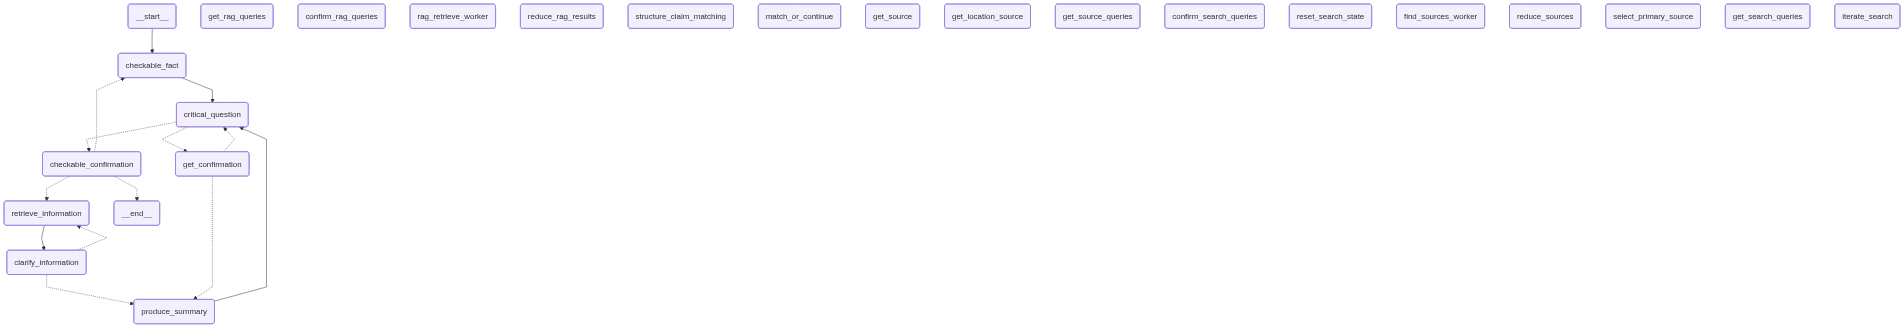

In [7]:
# ───────────────────────────────────────────────────────────────────────
# CLAIM GRAPH
# ───────────────────────────────────────────────────────────────────────
from claim_nodes import checkable_fact,checkable_confirmation,retrieve_information,clarify_information,produce_summary,get_confirmation
from langgraph.graph import StateGraph, START, END
from state_scope import AgentStateClaim

claim = StateGraph(AgentStateClaim)

#getting all info about the claim nodes
claim.add_node("checkable_fact", checkable_fact)
claim.add_node("checkable_confirmation", checkable_confirmation)
claim.add_node("retrieve_information", retrieve_information)
claim.add_node("clarify_information", clarify_information)
claim.add_node("produce_summary", produce_summary)
claim.add_node("get_confirmation", get_confirmation)
claim.add_node("critical_question", critical_question)

#Claim matching nodes
claim.add_node("get_rag_queries", get_rag_queries)
claim.add_node("confirm_rag_queries", confirm_rag_queries)
claim.add_node("rag_retrieve_worker", rag_retrieve_worker)
claim.add_node("reduce_rag_results", reduce_rag_results)
claim.add_node("structure_claim_matching", structure_claim_matching)
claim.add_node("match_or_continue", match_or_continue)

# Source finding nodes and search query nodes
claim.add_node("get_source", get_source)
claim.add_node("get_location_source", get_location_source)
claim.add_node("get_source_queries", get_source_queries)
claim.add_node("confirm_search_queries", confirm_search_queries)
claim.add_node("reset_search_state", reset_search_state)
claim.add_node("find_sources_worker", find_sources_worker)
claim.add_node("reduce_sources", reduce_sources)
claim.add_node("select_primary_source", select_primary_source)
claim.add_node("get_search_queries", get_search_queries)
claim.add_node("iterate_search",iterate_search)
#claim.add_node("router", router)

# Entry point
claim.add_edge(START, "checkable_fact")
claim.add_edge("checkable_fact", "critical_question")
claim.add_edge("retrieve_information", "clarify_information")
claim.add_edge("produce_summary", "critical_question")

# Connecting claim matching nodes
claim.add_edge("get_rag_queries", "confirm_rag_queries")
claim.add_conditional_edges("confirm_rag_queries", route_rag_confirm)
claim.add_edge("rag_retrieve_worker", "reduce_rag_results")
claim.add_edge("reduce_rag_results", "structure_claim_matching")

# Connecting source finding and search query nodes
claim.add_edge("get_source_queries", "critical_question")
claim.add_edge("get_search_queries", "critical_question")
claim.add_edge("confirm_search_queries", "reset_search_state")
claim.add_conditional_edges("reset_search_state", route_after_confirm)
claim.add_edge("find_sources_worker", "reduce_sources")
claim.add_edge("iterate_search", END)

claim_flow = claim.compile()

#visualization
try:
    from IPython.display import Image, display
    display(Image(claim_flow.get_graph().draw_mermaid_png()))
except Exception:
    pass
